<a href="https://colab.research.google.com/github/R09722akaBennett/Side_Project/blob/master/Use_social_article_to_make_investment_decision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Package

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!pip install monpa
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

In [3]:
# import package
import calendar
import csv
import monpa
import datetime
from monpa import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier   
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import ensemble
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")
import re
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.font_manager import fontManager

+---------------------------------------------------------------------+
  Welcome to MONPA: Multi-Objective NER POS Annotator for Chinese
+---------------------------------------------------------------------+
已找到 model檔。Found model file.


# Data Preprocessing

## Import all data

In [4]:
bbs_19_21= pd.read_csv('/content/gdrive/Shareddrives/Big Data and Business Analytic/midterm_project/bda2022_dataset 2/bda2022_mid_bbs_2019-2021.csv',encoding='utf8')
forum_19 = pd.read_csv('/content/gdrive/Shareddrives/Big Data and Business Analytic/midterm_project/bda2022_dataset 2/bda2022_mid_forum_2019.csv',encoding='utf8')
forum_20 = pd.read_csv('/content/gdrive/Shareddrives/Big Data and Business Analytic/midterm_project/bda2022_dataset 2/bda2022_mid_forum_2020.csv',encoding='utf8')
forum_21 = pd.read_csv('/content/gdrive/Shareddrives/Big Data and Business Analytic/midterm_project/bda2022_dataset 2/bda2022_mid_forum_2021.csv',encoding='utf8')
news_19 = pd.read_csv('/content/gdrive/Shareddrives/Big Data and Business Analytic/midterm_project/bda2022_dataset 2/bda2022_mid_news_2019.csv',encoding='utf8')
news_20 = pd.read_csv('/content/gdrive/Shareddrives/Big Data and Business Analytic/midterm_project/bda2022_dataset 2/bda2022_mid_news_2020.csv',encoding='utf8')
news_21 = pd.read_csv('/content/gdrive/Shareddrives/Big Data and Business Analytic/midterm_project/bda2022_dataset 2/bda2022_mid_news_2021.csv',encoding='utf8')

In [6]:
# Merge 2019,2020,2021 data
forum_all = pd.concat([forum_19,forum_20,forum_21])
news_all = pd.concat([news_19,news_20,news_21])

In [7]:
# Check data size
print(len(forum_19)+len(forum_20)+len(forum_21))
print(len(news_19)+len(news_20)+len(news_21))
print(len(bbs_19_21))
print(len(forum_19)+len(forum_20)+len(forum_21)+len(news_19)+len(news_20)+len(news_21)+len(bbs_19_21))

518957
587392
104466
1210815


In [8]:
# Convert data into dataframe
bbs_19_21 = pd.DataFrame(bbs_19_21)
forum_all = pd.DataFrame(forum_all)
news_all = pd.DataFrame(news_all)

In [9]:
# Merge all data
text_all = pd.concat([bbs_19_21,forum_all,news_all])
text_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1210815 entries, 0 to 180837
Data columns (total 11 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   id             1210815 non-null  object 
 1   p_type         1210815 non-null  object 
 2   s_name         1210815 non-null  object 
 3   s_area_name    1210815 non-null  object 
 4   post_time      1210815 non-null  object 
 5   title          1210815 non-null  object 
 6   author         1210815 non-null  object 
 7   content        1202627 non-null  object 
 8   page_url       1210815 non-null  object 
 9   content_type   518957 non-null   object 
 10  comment_count  518957 non-null   float64
dtypes: float64(1), object(10)
memory usage: 110.9+ MB


## Remove empty content, duplicated and keep chinese character only

In [10]:
# Remove empty content
text_all = text_all.dropna(subset=['content'])
text_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1202627 entries, 0 to 180837
Data columns (total 11 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   id             1202627 non-null  object 
 1   p_type         1202627 non-null  object 
 2   s_name         1202627 non-null  object 
 3   s_area_name    1202627 non-null  object 
 4   post_time      1202627 non-null  object 
 5   title          1202627 non-null  object 
 6   author         1202627 non-null  object 
 7   content        1202627 non-null  object 
 8   page_url       1202627 non-null  object 
 9   content_type   510808 non-null   object 
 10  comment_count  510808 non-null   float64
dtypes: float64(1), object(10)
memory usage: 110.1+ MB


In [11]:
# Keep chinese character
text_all.content = text_all.content.str.replace('[^\u4e00-\u9fa5]','')
text_all.title = text_all.title.str.replace('[^\u4e00-\u9fa5]','')

In [12]:
# Count duplicated title and content (total : 125025)
duplicate_all = text_all[text_all.duplicated(subset =['title','content'],keep=False)]
duplicate_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125025 entries, 83 to 180837
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             125025 non-null  object 
 1   p_type         125025 non-null  object 
 2   s_name         125025 non-null  object 
 3   s_area_name    125025 non-null  object 
 4   post_time      125025 non-null  object 
 5   title          125025 non-null  object 
 6   author         125025 non-null  object 
 7   content        125025 non-null  object 
 8   page_url       125025 non-null  object 
 9   content_type   30019 non-null   object 
 10  comment_count  30019 non-null   float64
dtypes: float64(1), object(10)
memory usage: 11.4+ MB


In [13]:
# Count title and content duplicated (total : 1202627-105969 = 1096658)
text_1 = text_all.drop_duplicates(subset=['title','content'], keep='first', inplace=False)
text_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1096658 entries, 0 to 180836
Data columns (total 11 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   id             1096658 non-null  object 
 1   p_type         1096658 non-null  object 
 2   s_name         1096658 non-null  object 
 3   s_area_name    1096658 non-null  object 
 4   post_time      1096658 non-null  object 
 5   title          1096658 non-null  object 
 6   author         1096658 non-null  object 
 7   content        1096658 non-null  object 
 8   page_url       1096658 non-null  object 
 9   content_type   486201 non-null   object 
 10  comment_count  486201 non-null   float64
dtypes: float64(1), object(10)
memory usage: 100.4+ MB


In [14]:
# Count title duplicated (Total : 542450)
duplicate_title = text_1[text_1.title.duplicated(keep='first')]
duplicate_title.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 542450 entries, 7 to 180736
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             542450 non-null  object 
 1   p_type         542450 non-null  object 
 2   s_name         542450 non-null  object 
 3   s_area_name    542450 non-null  object 
 4   post_time      542450 non-null  object 
 5   title          542450 non-null  object 
 6   author         542450 non-null  object 
 7   content        542450 non-null  object 
 8   page_url       542450 non-null  object 
 9   content_type   461040 non-null  object 
 10  comment_count  461040 non-null  float64
dtypes: float64(1), object(10)
memory usage: 49.7+ MB


In [15]:
# Count content duplicated (Total : 18281)
duplicate_content = text_1[text_1.content.duplicated(keep='first')]
duplicate_content.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18281 entries, 1681 to 180250
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             18281 non-null  object 
 1   p_type         18281 non-null  object 
 2   s_name         18281 non-null  object 
 3   s_area_name    18281 non-null  object 
 4   post_time      18281 non-null  object 
 5   title          18281 non-null  object 
 6   author         18281 non-null  object 
 7   content        18281 non-null  object 
 8   page_url       18281 non-null  object 
 9   content_type   10307 non-null  object 
 10  comment_count  10307 non-null  float64
dtypes: float64(1), object(10)
memory usage: 1.7+ MB


In [16]:
# Remove content duplicated
text_1 = text_all.drop_duplicates(subset='content', keep='first', inplace=False)
text_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1078377 entries, 0 to 180836
Data columns (total 11 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   id             1078377 non-null  object 
 1   p_type         1078377 non-null  object 
 2   s_name         1078377 non-null  object 
 3   s_area_name    1078377 non-null  object 
 4   post_time      1078377 non-null  object 
 5   title          1078377 non-null  object 
 6   author         1078377 non-null  object 
 7   content        1078377 non-null  object 
 8   page_url       1078377 non-null  object 
 9   content_type   475894 non-null   object 
 10  comment_count  475894 non-null   float64
dtypes: float64(1), object(10)
memory usage: 98.7+ MB


In [17]:
# Remove content length less thn 50 words
text_1 = text_1[text_1.content.str.len()>=50]
text_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 763387 entries, 0 to 180836
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             763387 non-null  object 
 1   p_type         763387 non-null  object 
 2   s_name         763387 non-null  object 
 3   s_area_name    763387 non-null  object 
 4   post_time      763387 non-null  object 
 5   title          763387 non-null  object 
 6   author         763387 non-null  object 
 7   content        763387 non-null  object 
 8   page_url       763387 non-null  object 
 9   content_type   181631 non-null  object 
 10  comment_count  181631 non-null  float64
dtypes: float64(1), object(10)
memory usage: 69.9+ MB


In [19]:
# Split data by platform type
bbs_19_21_nonduplicated =text_1[text_1.p_type=='bbs']
news_19_21_nonduplicated =text_1[text_1.p_type=='news']
forum_19_21_nonduplicated =text_1[text_1.p_type=='forum']

## Remove useless content



In [20]:
# BBS_data Total = 96604- keywords_to_remove 15722 - author_to_remove 115 = 80767
keywords_bbs = ['公告', '參選', '宣判', '問卷','上次故鄉','祝','發文規範']
author =['tim0259','annz']
bbs_19_21_nonduplicated = bbs_19_21_nonduplicated[~ (bbs_19_21_nonduplicated.title + bbs_19_21_nonduplicated.content).str.contains('|'.join(keywords_bbs))]
bbs_19_21_nonduplicated = bbs_19_21_nonduplicated[~ bbs_19_21_nonduplicated.author.str.contains('|'.join(author))]
bbs_19_21_nonduplicated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80767 entries, 1 to 104465
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             80767 non-null  object 
 1   p_type         80767 non-null  object 
 2   s_name         80767 non-null  object 
 3   s_area_name    80767 non-null  object 
 4   post_time      80767 non-null  object 
 5   title          80767 non-null  object 
 6   author         80767 non-null  object 
 7   content        80767 non-null  object 
 8   page_url       80767 non-null  object 
 9   content_type   0 non-null      object 
 10  comment_count  0 non-null      float64
dtypes: float64(1), object(10)
memory usage: 7.4+ MB


In [22]:
# Forum data =  181631 - keyword)to_remove 13407- If content_type = main and reply count <10 9870 = 158354
keywords_forum = ['公告','實踐財富價值', '分享','請問', '推薦', '信用卡', '活動','蝦蝦果園集中串','有錢沒錢蓋個大樓好過年','台大哲學系教授苑舉正','有獎問卷','免費講座','誠徵家庭代工','樂天網銀序號','關於補習班']
forum_19_21_nonduplicated = forum_19_21_nonduplicated[~forum_19_21_nonduplicated.title.str.contains('|'.join(keywords))]
forum_19_21_nonduplicated = forum_19_21_nonduplicated[~((forum_19_21_nonduplicated.content_type == 'main')&(forum_19_21_nonduplicated.comment_count<10))]

In [23]:
# check data length
print(len(bbs_19_21_nonduplicated))
print(len(forum_19_21_nonduplicated))
print(len(news_19_21_nonduplicated))
print(len(bbs_19_21_nonduplicated)+len(forum_19_21_nonduplicated)+len(news_19_21_nonduplicated))

80767
158354
485152
724273


## Export clean data

In [24]:
# export clean data
bbs_19_21_nonduplicated.to_csv('/content/gdrive/Shareddrives/Big Data and Business Analytic/midterm_project/清理過資料/bbs_19_21_cleaned.csv',encoding='utf-8')
news_19_21_nonduplicated.to_csv('/content/gdrive/Shareddrives/Big Data and Business Analytic/midterm_project/清理過資料/news_19_21_cleaned.csv',encoding='utf-8')
forum_19_21_nonduplicated.to_csv('/content/gdrive/Shareddrives/Big Data and Business Analytic/midterm_project/清理過資料/forum_19_21_cleaned.csv',encoding='utf-8')

## Stock Price

In [25]:
# Read stock data
def stock_file(stock_path):
    sheetname = input('上市or上櫃 / 年度 : ')
    stock = pd.read_excel(stock_path, sheet_name = sheetname)
    # 拉出證券代碼
    stock[['證券代碼', '公司名稱']] = stock['證券代碼'].str.split(' ', 1, expand=True)
    return stock

In [ ]:
stock = stock_file('/content/gdrive/Shareddrives/Big Data and Business Analytic/midterm_project/bda2022_dataset 2/stock_data_2019-2021.xlsx')

上市or上櫃 / 年度 : 上市2020


In [ ]:
# Extract data column , count ups and downs for N+3 day
def diff(x):
    return (x[3]-x[0])/x[0] * 100

def eval1(x):
    if x >0:
        label = '漲'
    elif x <0:
        label = '跌'
    else:
        label = '無變化'
    return label
    
def stock_price(stock_file):
    company_ = input('證券代碼 : ')
    company_name = stock_file[stock_file['證券代碼'].str.startswith(str(company_))]
    company_name['年月日'] = pd.to_datetime(company_name['年月日']).dt.date
    company_name = company_name.sort_values(by = '年月日').reset_index(drop = True)
    company_name = company_name[['證券代碼','公司名稱', '年月日', '收盤價(元)']]
    company_name['單日漲跌幅(%)'] = company_name['收盤價(元)'].rolling(4).apply(diff, raw = True)
    company_name['label'] = company_name['單日漲跌幅(%)'].apply(eval1)
    return company_name

## Article

In [ ]:
# Extract related article
def company_text(text_path):
    input_company_name = input("相關文章 : ")
    text_path = text_path[text_path['title'].str.contains(input_company_name) | text_path['content'].str.contains(input_company_name)].reset_index(drop = True)
    return text_path

In [ ]:
# Tagging ups and downs
def map_date(text_path, company_name) :
    text_path['post_time'] = pd.to_datetime(text_path['post_time']).dt.date
    company_name['年月日-3'] = company_name['年月日'] - datetime.timedelta(days=3)
    text_path = pd.merge(text_path, company_name, left_on='post_time', right_on='年月日-3')[['post_time', 'title', 'content', 'label']]
    return text_path, company_name

In [ ]:
# Import clean data
bbs_19_21= pd.read_csv('/content/gdrive/Shareddrives/Big Data and Business Analytic/midterm_project/清理過資料/bbs_19_21_cleaned.csv',encoding='utf-8')
forum_19_21= pd.read_csv('/content/gdrive/Shareddrives/Big Data and Business Analytic/midterm_project/清理過資料/forum_19_21_cleaned.csv',encoding='utf-8')
news_19_21= pd.read_csv('/content/gdrive/Shareddrives/Big Data and Business Analytic/midterm_project/清理過資料/news_19_21_cleaned.csv',encoding='utf-8')

In [ ]:
# Union all data
text_all = pd.concat([bbs_19_21,forum_19_21,news_19_21])

In [ ]:
text_data,stock_data = map_date(company_text(text_all),stock_price(stock))

相關文章 : 長榮
證券代碼 : 2603


In [ ]:
text_data

,post_time,title,content,label
0,2020-01-04,其他集中市場外資買賣超前名,買超代碼名稱買超張數華邦電元大原油正旺宏鴻海亞光元大台灣反彩晶富邦金富邦國票金南亞科台達電長...,漲
1,2020-01-10,其他集中市場三大法人買賣超前名,買超代碼名稱外資投信自營商合計買賣超群創元大原油反鴻海長榮元大全球未來通訊玉山金欣興第一金兆...,漲
2,2020-01-10,國際產業中東情勢緊張航空公司避開兩伊領空,由於美國與伊朗近來衝突升溫許多航空公司相繼宣布調整航線避開伊朗與伊拉克領空但航程變長使得燃料...,漲
3,2020-01-10,投信個股週四日投信買超賣超個股一覽表,買超張數如下代號個股張數群創中信金開發金南亞科華通佳世達中鋼聯茂兆豐金永豐金台新金力成合庫金...,漲
4,2020-01-10,外資買超股晶電群創台積電,經統計前個交易日外資連續買超五日以上的股票新普日盛金中興電久元連續買超四日的股票華通連續買超...,漲
...,...,...,...,...
1334,2020-12-06,六都首長最新網路聲量出爐第一名是這大咖,六都首長最新網路聲量排行出爐以台北市長柯文哲網路聲量最高第二名是高雄市長陳其邁佔人新聞聲量中...,漲
1335,2020-12-07,早報非農報告數據差美股反創高道瓊突破萬點,開盤日出刊傳明年來台電信三雄洽談中可望受惠官股券商逢高減碼但上週逆勢買檔群創居冠購物旺季表現...,漲
1336,2020-12-07,台股盤中再創新高面板股爆量開高走低,中央社記者蔡芃敏台北年月日電在晶圓雙雄領軍下台股早盤大漲超過點衝上點再寫新高不過盤中漲勢稍收...,漲
1337,2020-12-07,外資上週賣超億賣超長榮航最多,中央社記者潘智義台北年月日電台灣證券交易所今天公布上週外資在集中市場賣超新台幣億元賣超長榮航...,漲


In [ ]:
pd.set_option('display.max_rows', None)
stock_data

,證券代碼,公司名稱,年月日,收盤價(元),單日漲跌幅(%),label,年月日-3
0,2603,長榮,2020-01-02,12.70,NaN,無變化,2019-12-30
1,2603,長榮,2020-01-03,13.00,NaN,無變化,2019-12-31
2,2603,長榮,2020-01-06,13.00,NaN,無變化,2020-01-03
3,2603,長榮,2020-01-07,12.90,1.574803,漲,2020-01-04
4,2603,長榮,2020-01-08,12.60,-3.076923,跌,2020-01-05
5,2603,長榮,2020-01-09,12.85,-1.153846,跌,2020-01-06
6,2603,長榮,2020-01-10,13.15,1.937984,漲,2020-01-07
7,2603,長榮,2020-01-13,13.15,4.365079,漲,2020-01-10
8,2603,長榮,2020-01-14,13.20,2.723735,漲,2020-01-11
9,2603,長榮,2020-01-15,13.15,0.000000,無變化,2020-01-12


# Vertorize Training and Testing data
1. Cut Sentence
2. Tokenize

In [ ]:

# Using 1st and 3rd month as training_data and 4th month as testing_data
def get_train_tokenStr_list(text_path):
    # User can define starting date and ending date for training data
    startYear = int(input('Start Date for training (年) :'))
    startMonth = int(input('Start Date for training (月) :'))
    startDate = int(input('Start Date for training(日) :'))
    train_startDate = datetime.date(startYear,startMonth,startDate)
    endYear = int(input('End Date for training (年) :'))
    endMonth = int(input('End Date for training (月) :'))
    endDate = int(input('End Date for training (日) :'))
    train_endDate = datetime.date(endYear,endMonth,endDate)
    # Using monpa to tokenize article and save in tokenStr_list
    train_tokenStr_list = []
    for i in list(text_path[text_path['post_time'].between(train_startDate, train_endDate)].index):
        try:
            sentence_list = utils.short_sentence(text_path['content'][i])
            tokenStr = str()
            for sentence in sentence_list:
                tokens = monpa.cut(sentence)
                for t in tokens:
                    t=t.strip()
                    if (len(t)>1):
                        tokenStr += ' '+(t)
            train_tokenStr_list.append(tokenStr)
        except:
            train_tokenStr_list.append('')
    return train_tokenStr_list,train_startDate,train_endDate

def get_test_tokensStr_list(text_path):
    # User can define starting date and ending date for testing data
    startYear = int(input('Start Date for test(年) :'))
    startMonth = int(input('Start Date for test(月) :'))
    startDate = int(input('Start Date for test(日) :'))
    test_startDate = datetime.date(startYear,startMonth,startDate)
    endYear = int(input('End Date for test(年) :'))
    endMonth = int(input('End Date for test(月) :'))
    endDate = int(input('End Date for test(日) :'))
    test_endDate = datetime.date(endYear,endMonth,endDate)
    # Using monpa to tokenize article and save in tokenStr_list
    test_tokenStr_list = []
    for i in list(text_path[text_path['post_time'].between(test_startDate, test_endDate)].index):
        try:
            sentence_list = utils.short_sentence(text_path['content'][i])
            tokenStr = str()
            for sentence in sentence_list:
                tokens = monpa.cut(sentence)
                for t in tokens:
                    t=t.strip()
                    if (len(t)>1):
                        tokenStr += ' '+(t)
            test_tokenStr_list.append(tokenStr)
        except:
            test_tokenStr_list.append('')
    return test_tokenStr_list,test_startDate,test_endDate

Set starting point on 2020/1 and end point on 2020/3/31 as training data

In [ ]:
train_list,train_startDate,train_endDate = get_train_tokenStr_list(text_data)

Start Date for training (年) :2020
Start Date for training (月) :1
Start Date for training(日) :1
End Date for training (年) :2020
End Date for training (月) :3
End Date for training (日) :31


Set starting point on 2020/4/1 and end point on 2020/4/30 as testing data

In [ ]:
test_list,test_startDate,test_endDate = get_test_tokensStr_list(text_data)

Start Date for test(年) :2020
Start Date for test(月) :4
Start Date for test(日) :1
End Date for test(年) :2020
End Date for test(月) :4
End Date for test(日) :30


In [ ]:
train_list

[' 超代碼 名稱 張數 華邦電元大原油正旺宏 鴻海亞光元大台灣反彩晶富邦金富邦國票金南亞科 台達電 長榮奇力新群 台積電元大石油國泰金晶電嘉聯益美律 台塑華新科亞太電元大 黃金 正可成 富邦 証正兆豐金聯鈞大毅 華通元大 滬深正京元電子 欣興友達聯茂中環聯詠英業達永豐金和鑫亞泥榮成台泥聯電 燿華台紙 奇鋐 仁寶合勤控南電新光金文曄聯發科 和碩 國產 寶成佳世達 錸德 廣達 石油 黃金 意外 台灣 注意 一下 同時 入場 雖然 還是 超台積電然 垃圾 文曄 代表 外資 併購',
 ' 代碼 名稱 外資 投信 自營商 合計 買賣 超群創 元大 原油 鴻海 長榮元大 全球 未來 通訊 玉山金欣興 第一 兆豐金華通富邦晶電英業達上銀中壽 微星廣達緯創彩晶敦泰南電 永豐金建準 華南金茂林大同正隆亞德客新日 興賣 代碼 名稱 外資 投信 自營商 合計 買賣 元大原油正國泰股利精選元大台灣反富邦行動通訊聯電 友達金像電元大 台灣 元大 滬深正 開發金 旺宏中石化亞光東元國泰金中信金聯發科 嘉聯益金寶遠傳奇鋐 元大高股息巨大臺企銀 台灣大聯茂中環台光 揚智 亞泥',
 ' 由於 美國 伊朗 近來 衝突 升溫 許多 航空 公司 相繼 宣布 調整 航線 避開 伊朗 伊拉克 領空 航程 變長 使得 燃料 成本 大增 對於 面臨 波音 客機 停飛 損失 航空業 再次 帶來 經濟 衝擊 伊朗日 針對 美軍 位於 伊拉克 基地 展開 飛彈 攻擊 經過 小時 烏克蘭 國際 航空 公司 客機 伊朗 墜毀 失事 原因 進一步 調查 為了 確保 航行 安全 德國 漢莎航空 法荷航集團 新加坡 航空 馬來西亞 航空 公司 宣布 調整 飛航 路線 避免 經過 伊朗 伊拉克 領空 台灣 華航 長榮 航空日 宣布 飛往 航班 避開 兩伊 領空 未來 情況 調整 專家 表示 中東 緊張 情勢 升溫 航空 公司 調整 航線 預估 影響 乘客 高達 平均 航程 時間 增加 分鐘 連帶 導致 航空 公司 燃料 成本 攀升 獲利 銳減 澳洲 航空 由於 繞道 緣故 澳洲 柏斯 飛往 英國 倫敦 航班 時間 增加 分鐘 航空 公司 為了 載運 更多 燃料 被迫 縮減 乘客 人數 連帶 導致 營收 下滑 航空 專家 馬丁 表示 若是 美國 伊朗 兩國 真的 開戰 當其衝 航空業 指出 至少 航班 途經 領空 美國 聯邦航

In [ ]:
test_list

[' 原文 連結 原文 內容 國籍 航空 公司 賺錢 方式 客機 可以 貨機 載貨 因應 新冠 肺炎 疫情 愈來愈 嚴峻 客機 旅客 國籍 航空 公司 希望 比照 國外 開放 現有 客機 客艙 載貨 減少 虧損 交通部民航局 近日 完成 相關 規範 訂定 口頭 告知 航空 公司 下周 一日 發函 航空 公司 提出 申請 指出 新冠 肺炎 疫情 延燒 全球 影響 宣布 禁止 旅客 入境 使得 過去 很多 貨物 客機 機腹貨艙 運送 貨物 現在 完全 無法 飛航 倚靠 貨機 載送 貨機 數量 有限 全球 物品 防疫 物資 電子 零組件 貨機 運送 導致 近期 航空 運費 大漲 尚且 應求 國外 航空 業者 客機 客艙 載貨 完全 彌補 貨艙 不足 狀況 國籍 航空 公司 獲悉 民航局 詢問 是否 比照 辦理 民航局 標準組 官員 蒐集 資料 研究 訂定出 客艙 載貨 作業 準則 相關 官員 今日 表示 客機 載貨 形式 現有 客機 機腹 貨艙 載貨 客艙 航空 公司 只要 航線 航權 援用 原來 班號 網站 標明 客機 搭載 旅客 載貨 模式 相當 單純 近期 包括 長榮星宇 民航局 申請 獲准 飛航 客艙 載貨 模式 稍微 複雜 一點 原則 放置 物品 地方 機艙 行李 放置 處座椅 下方 座椅 物品 高度 超過 椅背 必須 網帶 固定 而且 客艙 攜帶 電池 火機 酒精等 當成 貨物 載送 官員 原本 客機 客艙 空服員 客艙 載貨 不需 任何 空服員 至少 客艙 任何 狀況 可以 立即 處理 飛航 告知 對方 另外 物品 放置 符合 載重 平衡 規定 了解 包括 華航 長榮華信 航空公司 民航局 詢問 客艙 載貨 規定 民航局 完成 相關 作業 準則 口頭 告知 航空 公司 周一 發函 航空 公司 提出 申請 心得 評論 航空股 最近 不會 客艙 可以 載貨 可以 舒緩 航空業 壓力 海空運 承攬業 之前 一直 應求 運價 上漲 知道 這樣 對於 產業 而言 利多 還是 利空 大家 怎麼',
 ' 前陣子 大跌 大家 跌勢版 興起 風氣 那邊 擦鞋 童理論 恥笑 大媽 菜籃族 一窩蜂 不知 死活 巴拉巴拉 結果 真的 止跌 反彈 當初 進場 現在 至少 隨便 以上 甚至 更多 小弟 無聊 抱持 賭博 心態 進了 華航 官股 怎麼 這樣 大不了 漲上去 入袋為安 結

# Vectorize training and testing data

In [ ]:
# Import Stopwords
with open('/content/gdrive/Shareddrives/Big Data and Business Analytic/midterm_project/bda2022_dataset 2/stopwords_zh.txt', 'r') as file:
    stopwords = file.read().splitlines() 
file.close()

In [ ]:
vectorizer = TfidfVectorizer(stop_words=stopwords)
X_train = vectorizer.fit_transform(train_list)
X_train = pd.DataFrame(X_train.toarray(),columns=vectorizer.get_feature_names())
X_train

,一中,一二級,一八年度,一半,一口,一口氣,一同,一季,一度,一成,...,鼻青臉腫,齊漲,齊發,齊賣,齊跌,龍巖,龍頭,龍頭廠,龍頭股,龐大
0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
y_train = text_data[text_data['post_time'].between(train_startDate, train_endDate)]['label']
y_train

0         漲
1         漲
2         漲
3         漲
4         漲
5         漲
6         漲
7         漲
8         漲
9         漲
10        漲
11        漲
12        漲
13        漲
14        漲
15        漲
16        跌
17        跌
18        跌
19        跌
20        跌
21        跌
22        跌
23        跌
24        跌
25        跌
26        跌
27        跌
28        跌
29        跌
30        跌
31        跌
32        跌
33        跌
34        跌
35        跌
36        跌
37        跌
38        跌
39        跌
40        跌
41        跌
42        跌
43        跌
44        漲
45        漲
46        漲
47        漲
48        漲
49        漲
50        漲
51        漲
52        漲
53        漲
54        跌
55        跌
56        跌
57        漲
58        漲
59        漲
60      無變化
61        漲
62        漲
63        跌
64        跌
65        跌
66        跌
67        跌
68        跌
69        跌
70        跌
71        跌
72        跌
73        跌
74        跌
75        跌
76        跌
77        跌
78        跌
79        跌
80        跌
81        跌
82        跌
83  

In [ ]:
chi2_selector = SelectKBest(chi2, k = 2000)
chi2_selector.fit(X_train, y_train)
kbest_vocabs = X_train.columns[chi2_selector.get_support()]
X_train = X_train[kbest_vocabs]
X_train

,一二級,一覽表,一點,三商,三發,三百億,上千萬,上午,上半年,上周,...,黃金正,黃金正恆大,黃金正東科達運,黃金正華邦電,默默撿便宜,點美,鼎力成,齊漲,齊跌,龐大
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.176271,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# Reindex testing data result and map onto training data
y_test = text_data[text_data['post_time'].between(test_startDate, test_endDate)]['label']

vectorizer = TfidfVectorizer(stop_words=stopwords)
X_test = vectorizer.fit_transform(test_list)
X_test = pd.DataFrame(X_test.toarray(),columns=vectorizer.get_feature_names())
X_test = X_test.reindex(kbest_vocabs, axis=1, fill_value=0)
X_test

,一二級,一覽表,一點,三商,三發,三百億,上千萬,上午,上半年,上周,...,黃金正,黃金正恆大,黃金正東科達運,黃金正華邦電,默默撿便宜,點美,鼎力成,齊漲,齊跌,龐大
0,0,0.000000,0.041368,0,0,0,0,0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,0,0.000000,0.000000,0,0,0,0,0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,0,0.000000,0.000000,0,0,0,0,0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,0,0.000000,0.000000,0,0,0,0,0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,0,0.000000,0.000000,0,0,0,0,0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
5,0,0.000000,0.000000,0,0,0,0,0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
6,0,0.000000,0.000000,0,0,0,0,0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
7,0,0.000000,0.000000,0,0,0,0,0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
8,0,0.000000,0.000000,0,0,0,0,0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
9,0,0.000000,0.000000,0,0,0,0,0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


# Modeling, predict and output result
1.LogisticRegression<br>
2.RandomForest<br>
3.SVM<br>
4.GradientBoosting<br>
5.HistGradientBoosting<br>
6.SGDClassifier<br>
7.RidgeClassifierCV<br>
8.GaussianProcessClassifier<br>
9.XGBoosting<br>



## 0）Checking testing data

In [ ]:
# test_label = stock_data[stock_data['年月日-3'].between(test_startDate, test_endDate)]['label']
test_data = text_data[text_data['post_time'].between(test_startDate, test_endDate)]
test_data

,post_time,title,content,label
106,2020-04-04,新聞航空公司多一個賺錢方式客艙可以載貨了,原文連結原文內容國籍航空公司多一個賺錢方式客機可以當貨機載貨了因應新冠肺炎疫情愈來愈嚴峻客機...,漲
107,2020-04-10,心得根本就要反著看吧,前陣子大跌大家都說會有更猛的跌勢版上興起了一股我你先買的風氣還在那邊擦鞋童理論恥笑大媽菜籃族...,漲
108,2020-04-10,熱門族群檔銅板股逆勢鎖漲停,時報台北電台股日面臨月日跳空缺口反壓於萬點關卡上震盪整理近期主流族群普遍拉回修正反觀低基期的...,漲
109,2020-04-10,早報不畏疫情影響國泰金可望穩坐金控獲利王,開盤日出刊沙俄達減產協議每日減產量達萬桶大立光繳佳績但保守看待月展望再祭出兆美元救市道瓊收漲...,漲
110,2020-04-10,券商晨訊台股投資組合建議年月日,券商推薦股台積電精測玉晶光台郡鴻海和碩旭富華碩宏碁昱泉大宇資辣椒網龍長榮航華航長榮海四維航陽...,漲
111,2020-04-10,行情邁入雙軋空階段個股表現優於指數,多頭以迅雷不及掩耳的速度展開反彈行情到今天為止指數已經重回萬點大關成交量也連續天回到億以上但...,漲
112,2020-04-11,新聞長榮航三月營收,長榮航年月合併營收億元年增心得原本以為年增會是負以上而且這次的營收應該成是靠貨運來的客運賠錢...,跌
113,2020-04-11,產業疫情重傷營收老謝警告大慘業月會更糟,時報台北電上市櫃公司揭曉月營收不少公司受到疫情的影響營收大幅下滑財信傳媒董事長謝金河列舉出五...,跌
114,2020-04-11,財政啟動紓困億貸款助航空業,時報台北電新冠肺炎對民航產業造成衝擊遠超過期間行政院及交通部指示民航局超前部署啟動紓困計畫即...,跌
115,2020-04-13,其他台灣集中市場三大法人買賣超前三十,台灣集中市場三大法人買賣超前三十買超代碼名稱外資投信自營商合計買賣超中信金南電聯電鎧勝國泰美...,漲


## 1）LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression
import seaborn as sns

Rg = LogisticRegression(C=1.0, max_iter=100,random_state=1234)
Rg.fit(X_train,y_train)

y_predict = Rg.predict(X_test)

score: 0.30666666666666664
report:
               precision    recall  f1-score   support

           漲       0.00      0.00      0.00        52
           跌       0.31      1.00      0.47        23

    accuracy                           0.31        75
   macro avg       0.15      0.50      0.23        75
weighted avg       0.09      0.31      0.14        75



[Text(0, 0.5, '漲'), Text(0, 1.5, '跌'), Text(0, 2.5, '無變化')]

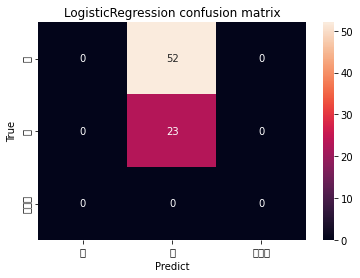

In [ ]:
# check confusion matrix
label_name = ["漲", "跌", "無變化"]
mat = confusion_matrix(y_test, y_predict, labels=label_name)

print("score:",Rg.score(X_test,y_test))
    
print("report:\n",classification_report(y_test,y_predict)) 
       
# show confusion matrix
ax = plt.subplot()
sns.heatmap(mat,annot=True, fmt='g', ax=ax)
# labels, title and ticks
ax.set_xlabel('Predict');ax.set_ylabel('True')
title_name = 'LogisticRegression' + ' ' + 'confusion matrix'
ax.set_title(title_name)
ax.xaxis.set_ticklabels(label_name)
ax.yaxis.set_ticklabels(label_name)

4月份預測準確率: 0.3333333333333333
              precision    recall  f1-score   support

           漲       0.00      0.00      0.00        10
           跌       0.33      1.00      0.50         5

    accuracy                           0.33        15
   macro avg       0.17      0.50      0.25        15
weighted avg       0.11      0.33      0.17        15



,年月日-3,label,predict_label3
0,2020-04-03,跌,跌
1,2020-04-04,漲,跌
2,2020-04-05,漲,跌
3,2020-04-06,漲,跌
4,2020-04-07,漲,跌
5,2020-04-10,漲,跌
6,2020-04-11,跌,跌
7,2020-04-13,漲,跌
8,2020-04-14,漲,跌
9,2020-04-17,跌,跌


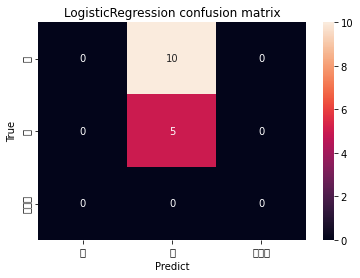

In [ ]:
# Predict
test_data['predict_label3'] = Rg.predict(X_test) 
# Count the most common article type of the day, and predict
def get_more_articles(x):
  df = x.sort_values(by = 'title',ascending=False)
  return df

predict_label3 = test_data.groupby(['post_time', 'predict_label3']).count().sort_values('predict_label3', ascending = False).sort_index(level=[0], sort_remaining=False).groupby('post_time',as_index=False).apply(get_more_articles).groupby(level=0).head(1).reset_index()[['post_time', 'predict_label3']]
test_label = stock_data[stock_data['年月日-3'].between(test_startDate, test_endDate)][['年月日-3','label']]

result = pd.merge(test_label, predict_label3, left_on="年月日-3", right_on="post_time", how="left").drop('post_time',axis=1)
result = result.fillna(value="不出手")

result_notNA = pd.merge(test_label, predict_label3, left_on="年月日-3", right_on="post_time").drop('post_time',axis=1)

print('{}月份預測準確率:'.format(test_startDate.month), accuracy_score(result_notNA['label'], result_notNA['predict_label3']))
print(classification_report(result_notNA['label'], result_notNA['predict_label3']))

# Confusion Matrix
label_name = ["漲", "跌", "無變化"]
cm = confusion_matrix(result_notNA['label'], result_notNA['predict_label3'], labels=label_name)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
# labels, title and ticks
ax.set_xlabel('Predict');ax.set_ylabel('True')
title_name = 'LogisticRegression' + ' ' + 'confusion matrix'
ax.set_title(title_name)
ax.xaxis.set_ticklabels(label_name)
ax.yaxis.set_ticklabels(label_name)

result_notNA


## 2）RandomForest

In [ ]:
from sklearn import ensemble
forest = ensemble.RandomForestClassifier(n_estimators = 100,random_state=1234)
forest_fit = forest.fit(X_train, y_train)
y_predict = forest.predict(X_test)

score: 0.30666666666666664
report:
               precision    recall  f1-score   support

           漲       0.00      0.00      0.00        52
           跌       0.31      1.00      0.47        23

    accuracy                           0.31        75
   macro avg       0.15      0.50      0.23        75
weighted avg       0.09      0.31      0.14        75



[Text(0, 0.5, '漲'), Text(0, 1.5, '跌'), Text(0, 2.5, '無變化')]

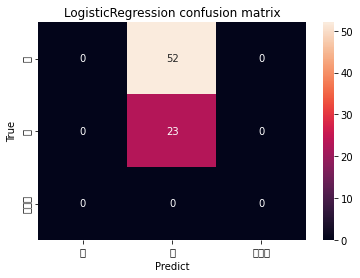

In [ ]:
# Check confusion matrix
label_name = ["漲", "跌", "無變化"]
mat = confusion_matrix(y_test, y_predict, labels=label_name)

print("score:",forest.score(X_test,y_test))
    
print("report:\n",classification_report(y_test,y_predict)) 
       
# Show confusion matrix
ax = plt.subplot()
sns.heatmap(mat,annot=True, fmt='g', ax=ax)
# labels, title and ticks
ax.set_xlabel('Predict');ax.set_ylabel('True')
title_name = 'LogisticRegression' + ' ' + 'confusion matrix'
ax.set_title(title_name)
ax.xaxis.set_ticklabels(label_name)
ax.yaxis.set_ticklabels(label_name)

4月份預測準確率: 0.3333333333333333
              precision    recall  f1-score   support

           漲       0.00      0.00      0.00        10
           跌       0.33      1.00      0.50         5

    accuracy                           0.33        15
   macro avg       0.17      0.50      0.25        15
weighted avg       0.11      0.33      0.17        15



,年月日-3,label,predict_label3
0,2020-04-03,跌,跌
1,2020-04-04,漲,跌
2,2020-04-05,漲,跌
3,2020-04-06,漲,跌
4,2020-04-07,漲,跌
5,2020-04-10,漲,跌
6,2020-04-11,跌,跌
7,2020-04-13,漲,跌
8,2020-04-14,漲,跌
9,2020-04-17,跌,跌


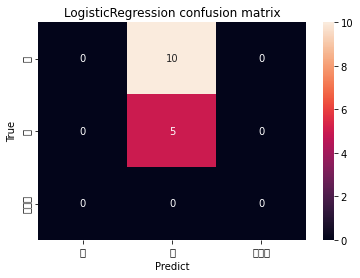

In [ ]:
# Predict
test_data['predict_label3'] = forest.predict(X_test) 
# Count the most common article type of the day, and predict
def get_more_articles(x):
  df = x.sort_values(by = 'title',ascending=False)
  return df

predict_label3 = test_data.groupby(['post_time', 'predict_label3']).count().sort_values('predict_label3', ascending = False).sort_index(level=[0], sort_remaining=False).groupby('post_time',as_index=False).apply(get_more_articles).groupby(level=0).head(1).reset_index()[['post_time', 'predict_label3']]
test_label = stock_data[stock_data['年月日-3'].between(test_startDate, test_endDate)][['年月日-3','label']]

result = pd.merge(test_label, predict_label3, left_on="年月日-3", right_on="post_time", how="left").drop('post_time',axis=1)
result = result.fillna(value="不出手")

result_notNA = pd.merge(test_label, predict_label3, left_on="年月日-3", right_on="post_time").drop('post_time',axis=1)

print('{}月份預測準確率:'.format(test_startDate.month), accuracy_score(result_notNA['label'], result_notNA['predict_label3']))
print(classification_report(result_notNA['label'], result_notNA['predict_label3']))

# Confusion Matrix
label_name = ["漲", "跌", "無變化"]
cm = confusion_matrix(result_notNA['label'], result_notNA['predict_label3'], labels=label_name)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
# labels, title and ticks
ax.set_xlabel('Predict');ax.set_ylabel('True')
title_name = 'LogisticRegression' + ' ' + 'confusion matrix'
ax.set_title(title_name)
ax.xaxis.set_ticklabels(label_name)
ax.yaxis.set_ticklabels(label_name)

result_notNA

In [ ]:
result

,年月日-3,label,predict_label3
0,2020-04-03,跌,跌
1,2020-04-04,漲,跌
2,2020-04-05,漲,跌
3,2020-04-06,漲,跌
4,2020-04-07,漲,跌
5,2020-04-10,漲,跌
6,2020-04-11,跌,跌
7,2020-04-12,漲,不出手
8,2020-04-13,漲,跌
9,2020-04-14,漲,跌


## 3）SVM

In [ ]:
from sklearn import svm

svc = svm.SVC(random_state=1234)
svc_fit = svc.fit(X_train, y_train)

# Predict
y_predict = svc.predict(X_test)

score: 0.30666666666666664
report:
               precision    recall  f1-score   support

           漲       0.00      0.00      0.00        52
           跌       0.31      1.00      0.47        23

    accuracy                           0.31        75
   macro avg       0.15      0.50      0.23        75
weighted avg       0.09      0.31      0.14        75



[Text(0, 0.5, '漲'), Text(0, 1.5, '跌'), Text(0, 2.5, '無變化')]

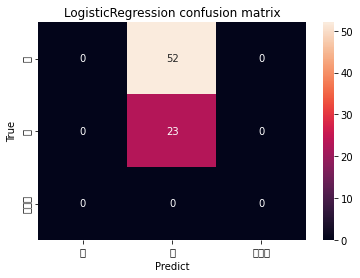

In [ ]:
# Check Confusion Matrix
label_name = ["漲", "跌", "無變化"]
mat = confusion_matrix(y_test, y_predict, labels=label_name)

print("score:",svc.score(X_test,y_test))
    
print("report:\n",classification_report(y_test,y_predict)) 
       
# Show confusion matrix
ax = plt.subplot()
sns.heatmap(mat,annot=True, fmt='g', ax=ax)
# labels, title and ticks
ax.set_xlabel('Predict');ax.set_ylabel('True')
title_name = 'LogisticRegression' + ' ' + 'confusion matrix'
ax.set_title(title_name)
ax.xaxis.set_ticklabels(label_name)
ax.yaxis.set_ticklabels(label_name)

4月份預測準確率: 0.3333333333333333
              precision    recall  f1-score   support

           漲       0.00      0.00      0.00        10
           跌       0.33      1.00      0.50         5

    accuracy                           0.33        15
   macro avg       0.17      0.50      0.25        15
weighted avg       0.11      0.33      0.17        15



,年月日-3,label,predict_label3
0,2020-04-03,跌,跌
1,2020-04-04,漲,跌
2,2020-04-05,漲,跌
3,2020-04-06,漲,跌
4,2020-04-07,漲,跌
5,2020-04-10,漲,跌
6,2020-04-11,跌,跌
7,2020-04-13,漲,跌
8,2020-04-14,漲,跌
9,2020-04-17,跌,跌


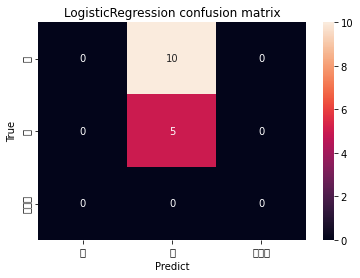

In [ ]:
# Predict
test_data['predict_label3'] = svc.predict(X_test) 
# Count the most common article type of the day, and predict
def get_more_articles(x):
  df = x.sort_values(by = 'title',ascending=False)
  return df

predict_label3 = test_data.groupby(['post_time', 'predict_label3']).count().sort_values('predict_label3', ascending = False).sort_index(level=[0], sort_remaining=False).groupby('post_time',as_index=False).apply(get_more_articles).groupby(level=0).head(1).reset_index()[['post_time', 'predict_label3']]
test_label = stock_data[stock_data['年月日-3'].between(test_startDate, test_endDate)][['年月日-3','label']]

result = pd.merge(test_label, predict_label3, left_on="年月日-3", right_on="post_time", how="left").drop('post_time',axis=1)
result = result.fillna(value="不出手")

result_notNA = pd.merge(test_label, predict_label3, left_on="年月日-3", right_on="post_time").drop('post_time',axis=1)

print('{}月份預測準確率:'.format(test_startDate.month), accuracy_score(result_notNA['label'], result_notNA['predict_label3']))
print(classification_report(result_notNA['label'], result_notNA['predict_label3']))

# Confusion Matrix
label_name = ["漲", "跌", "無變化"]
cm = confusion_matrix(result_notNA['label'], result_notNA['predict_label3'], labels=label_name)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
# labels, title and ticks
ax.set_xlabel('Predict');ax.set_ylabel('True')
title_name = 'LogisticRegression' + ' ' + 'confusion matrix'
ax.set_title(title_name)
ax.xaxis.set_ticklabels(label_name)
ax.yaxis.set_ticklabels(label_name)

result_notNA

In [ ]:
result

,年月日-3,label,predict_label3
0,2020-04-03,跌,跌
1,2020-04-04,漲,跌
2,2020-04-05,漲,跌
3,2020-04-06,漲,跌
4,2020-04-07,漲,跌
5,2020-04-10,漲,跌
6,2020-04-11,跌,跌
7,2020-04-12,漲,不出手
8,2020-04-13,漲,跌
9,2020-04-14,漲,跌


## 4）GradientBoosting

In [ ]:
GBC = ensemble.GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.05)
GBC_fit = GBC.fit(X_train, y_train)

# Predict
y_predict = GBC.predict(X_test)

score: 0.28
report:
               precision    recall  f1-score   support

           漲       0.25      0.02      0.04        52
         無變化       0.00      0.00      0.00         0
           跌       0.29      0.87      0.43        23

    accuracy                           0.28        75
   macro avg       0.18      0.30      0.16        75
weighted avg       0.26      0.28      0.16        75



[Text(0, 0.5, '漲'), Text(0, 1.5, '跌'), Text(0, 2.5, '無變化')]

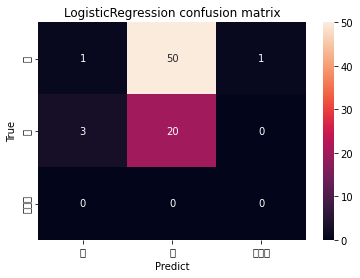

In [ ]:
# Check confusion matrix
label_name = ["漲", "跌", "無變化"]
mat = confusion_matrix(y_test, y_predict, labels=label_name)

print("score:",GBC.score(X_test,y_test))
    
print("report:\n",classification_report(y_test,y_predict)) 
       
# Show confusion matrix
ax = plt.subplot()
sns.heatmap(mat,annot=True, fmt='g', ax=ax)
# labels, title and ticks
ax.set_xlabel('Predict');ax.set_ylabel('True')
title_name = 'LogisticRegression' + ' ' + 'confusion matrix'
ax.set_title(title_name)
ax.xaxis.set_ticklabels(label_name)
ax.yaxis.set_ticklabels(label_name)

4月份預測準確率: 0.3333333333333333
              precision    recall  f1-score   support

           漲       0.00      0.00      0.00        10
           跌       0.33      1.00      0.50         5

    accuracy                           0.33        15
   macro avg       0.17      0.50      0.25        15
weighted avg       0.11      0.33      0.17        15



,年月日-3,label,predict_label3
0,2020-04-03,跌,跌
1,2020-04-04,漲,跌
2,2020-04-05,漲,跌
3,2020-04-06,漲,跌
4,2020-04-07,漲,跌
5,2020-04-10,漲,跌
6,2020-04-11,跌,跌
7,2020-04-13,漲,跌
8,2020-04-14,漲,跌
9,2020-04-17,跌,跌


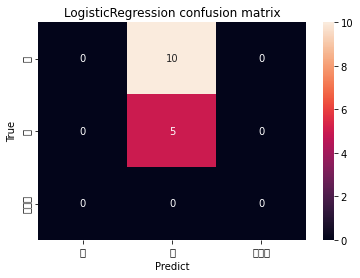

In [ ]:
# predict
test_data['predict_label3'] = GBC.predict(X_test) 
# Count the most common article type of the day, and predict
def get_more_articles(x):
  df = x.sort_values(by = 'title',ascending=False)
  return df

predict_label3 = test_data.groupby(['post_time', 'predict_label3']).count().sort_values('predict_label3', ascending = False).sort_index(level=[0], sort_remaining=False).groupby('post_time',as_index=False).apply(get_more_articles).groupby(level=0).head(1).reset_index()[['post_time', 'predict_label3']]
test_label = stock_data[stock_data['年月日-3'].between(test_startDate, test_endDate)][['年月日-3','label']]

result = pd.merge(test_label, predict_label3, left_on="年月日-3", right_on="post_time", how="left").drop('post_time',axis=1)
result = result.fillna(value="不出手")

result_notNA = pd.merge(test_label, predict_label3, left_on="年月日-3", right_on="post_time").drop('post_time',axis=1)

print('{}月份預測準確率:'.format(test_startDate.month), accuracy_score(result_notNA['label'], result_notNA['predict_label3']))
print(classification_report(result_notNA['label'], result_notNA['predict_label3']))

# Confusion Matrix
label_name = ["漲", "跌", "無變化"]
cm = confusion_matrix(result_notNA['label'], result_notNA['predict_label3'], labels=label_name)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
# labels, title and ticks
ax.set_xlabel('Predict');ax.set_ylabel('True')
title_name = 'LogisticRegression' + ' ' + 'confusion matrix'
ax.set_title(title_name)
ax.xaxis.set_ticklabels(label_name)
ax.yaxis.set_ticklabels(label_name)

result_notNA

In [ ]:
result

,年月日-3,label,predict_label3
0,2020-04-03,跌,跌
1,2020-04-04,漲,跌
2,2020-04-05,漲,跌
3,2020-04-06,漲,跌
4,2020-04-07,漲,跌
5,2020-04-10,漲,跌
6,2020-04-11,跌,跌
7,2020-04-12,漲,不出手
8,2020-04-13,漲,跌
9,2020-04-14,漲,跌


## 5）HistGradientBoostingClassifier

In [ ]:
HGBC = ensemble.HistGradientBoostingClassifier(learning_rate = 0.01)
HGBC_fit = HGBC.fit(X_train, y_train)

# Predict
y_predict = HGBC.predict(X_test)

score: 0.3333333333333333
report:
               precision    recall  f1-score   support

           漲       0.75      0.06      0.11        52
           跌       0.31      0.96      0.47        23

    accuracy                           0.33        75
   macro avg       0.53      0.51      0.29        75
weighted avg       0.62      0.33      0.22        75



[Text(0, 0.5, '漲'), Text(0, 1.5, '跌'), Text(0, 2.5, '無變化')]

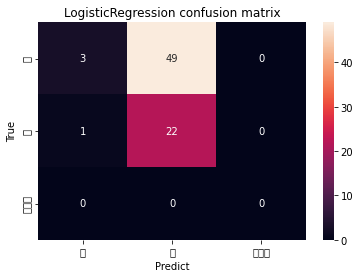

In [ ]:
# Check confusion matrix
label_name = ["漲", "跌", "無變化"]
mat = confusion_matrix(y_test, y_predict, labels=label_name)

print("score:",HGBC.score(X_test,y_test))
    
print("report:\n",classification_report(y_test,y_predict)) 
       
# Show confusion matrix
ax = plt.subplot()
sns.heatmap(mat,annot=True, fmt='g', ax=ax)
# labels, title and ticks
ax.set_xlabel('Predict');ax.set_ylabel('True')
title_name = 'LogisticRegression' + ' ' + 'confusion matrix'
ax.set_title(title_name)
ax.xaxis.set_ticklabels(label_name)
ax.yaxis.set_ticklabels(label_name)

4月份預測準確率: 0.4
              precision    recall  f1-score   support

           漲       1.00      0.10      0.18        10
           跌       0.36      1.00      0.53         5

    accuracy                           0.40        15
   macro avg       0.68      0.55      0.35        15
weighted avg       0.79      0.40      0.30        15



,年月日-3,label,predict_label3
0,2020-04-03,跌,跌
1,2020-04-04,漲,漲
2,2020-04-05,漲,跌
3,2020-04-06,漲,跌
4,2020-04-07,漲,跌
5,2020-04-10,漲,跌
6,2020-04-11,跌,跌
7,2020-04-13,漲,跌
8,2020-04-14,漲,跌
9,2020-04-17,跌,跌


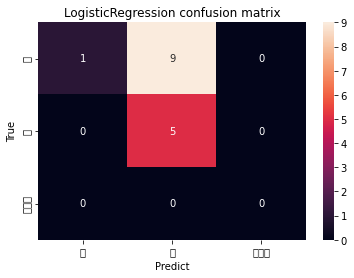

In [ ]:
# Predict
test_data['predict_label3'] = HGBC.predict(X_test) 
# Count the most common article type of the day, and predict
def get_more_articles(x):
  df = x.sort_values(by = 'title',ascending=False)
  return df

predict_label3 = test_data.groupby(['post_time', 'predict_label3']).count().sort_values('predict_label3', ascending = False).sort_index(level=[0], sort_remaining=False).groupby('post_time',as_index=False).apply(get_more_articles).groupby(level=0).head(1).reset_index()[['post_time', 'predict_label3']]
test_label = stock_data[stock_data['年月日-3'].between(test_startDate, test_endDate)][['年月日-3','label']]

result = pd.merge(test_label, predict_label3, left_on="年月日-3", right_on="post_time", how="left").drop('post_time',axis=1)
result = result.fillna(value="不出手")

result_notNA = pd.merge(test_label, predict_label3, left_on="年月日-3", right_on="post_time").drop('post_time',axis=1)

print('{}月份預測準確率:'.format(test_startDate.month), accuracy_score(result_notNA['label'], result_notNA['predict_label3']))
print(classification_report(result_notNA['label'], result_notNA['predict_label3']))

# confusion matrix
label_name = ["漲", "跌", "無變化"]
cm = confusion_matrix(result_notNA['label'], result_notNA['predict_label3'], labels=label_name)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
# labels, title and ticks
ax.set_xlabel('Predict');ax.set_ylabel('True')
title_name = 'LogisticRegression' + ' ' + 'confusion matrix'
ax.set_title(title_name)
ax.xaxis.set_ticklabels(label_name)
ax.yaxis.set_ticklabels(label_name)

result_notNA

In [ ]:
result

,年月日-3,label,predict_label3
0,2020-04-03,跌,跌
1,2020-04-04,漲,漲
2,2020-04-05,漲,跌
3,2020-04-06,漲,跌
4,2020-04-07,漲,跌
5,2020-04-10,漲,跌
6,2020-04-11,跌,跌
7,2020-04-12,漲,不出手
8,2020-04-13,漲,跌
9,2020-04-14,漲,跌


## 6）SGDClassifier

In [ ]:
from sklearn.linear_model import SGDClassifier

SGDC = SGDClassifier()
SGDC.fit(X_train,y_train)

y_predict = SGDC.predict(X_test)

score: 0.37333333333333335
report:
               precision    recall  f1-score   support

           漲       0.69      0.17      0.28        52
           跌       0.31      0.83      0.45        23

    accuracy                           0.37        75
   macro avg       0.50      0.50      0.36        75
weighted avg       0.57      0.37      0.33        75



[Text(0, 0.5, '漲'), Text(0, 1.5, '跌'), Text(0, 2.5, '無變化')]

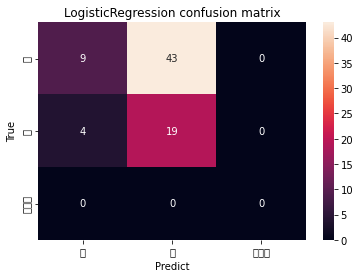

In [ ]:
# Check confusion matrix
label_name = ["漲", "跌", "無變化"]
mat = confusion_matrix(y_test, y_predict, labels=label_name)

print("score:",SGDC.score(X_test,y_test))
    
print("report:\n",classification_report(y_test,y_predict)) 
       
# Show confusion matrix
ax = plt.subplot()
sns.heatmap(mat,annot=True, fmt='g', ax=ax)
# labels, title and ticks
ax.set_xlabel('Predict');ax.set_ylabel('True')
title_name = 'LogisticRegression' + ' ' + 'confusion matrix'
ax.set_title(title_name)
ax.xaxis.set_ticklabels(label_name)
ax.yaxis.set_ticklabels(label_name)

4月份預測準確率: 0.4666666666666667
              precision    recall  f1-score   support

           漲       1.00      0.20      0.33        10
           跌       0.38      1.00      0.56         5

    accuracy                           0.47        15
   macro avg       0.69      0.60      0.44        15
weighted avg       0.79      0.47      0.41        15



,年月日-3,label,predict_label3
0,2020-04-03,跌,跌
1,2020-04-04,漲,漲
2,2020-04-05,漲,跌
3,2020-04-06,漲,漲
4,2020-04-07,漲,跌
5,2020-04-10,漲,跌
6,2020-04-11,跌,跌
7,2020-04-13,漲,跌
8,2020-04-14,漲,跌
9,2020-04-17,跌,跌


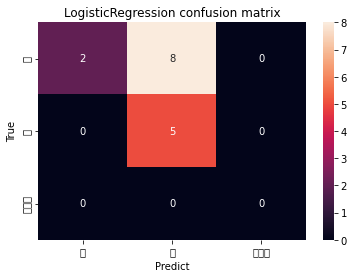

In [ ]:
# Predict
test_data['predict_label3'] = SGDC.predict(X_test) 
# Count the most common article type of the day, and predict
def get_more_articles(x):
  df = x.sort_values(by = 'title',ascending=False)
  return df

predict_label3 = test_data.groupby(['post_time', 'predict_label3']).count().sort_values('predict_label3', ascending = False).sort_index(level=[0], sort_remaining=False).groupby('post_time',as_index=False).apply(get_more_articles).groupby(level=0).head(1).reset_index()[['post_time', 'predict_label3']]
test_label = stock_data[stock_data['年月日-3'].between(test_startDate, test_endDate)][['年月日-3','label']]

result = pd.merge(test_label, predict_label3, left_on="年月日-3", right_on="post_time", how="left").drop('post_time',axis=1)
result = result.fillna(value="不出手")

result_notNA = pd.merge(test_label, predict_label3, left_on="年月日-3", right_on="post_time").drop('post_time',axis=1)

print('{}月份預測準確率:'.format(test_startDate.month), accuracy_score(result_notNA['label'], result_notNA['predict_label3']))
print(classification_report(result_notNA['label'], result_notNA['predict_label3']))

# Confusion Matrix
label_name = ["漲", "跌", "無變化"]
cm = confusion_matrix(result_notNA['label'], result_notNA['predict_label3'], labels=label_name)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
# labels, title and ticks
ax.set_xlabel('Predict');ax.set_ylabel('True')
title_name = 'LogisticRegression' + ' ' + 'confusion matrix'
ax.set_title(title_name)
ax.xaxis.set_ticklabels(label_name)
ax.yaxis.set_ticklabels(label_name)

result_notNA

In [ ]:
result

,年月日-3,label,predict_label3
0,2020-04-03,跌,跌
1,2020-04-04,漲,漲
2,2020-04-05,漲,跌
3,2020-04-06,漲,漲
4,2020-04-07,漲,跌
5,2020-04-10,漲,跌
6,2020-04-11,跌,跌
7,2020-04-12,漲,不出手
8,2020-04-13,漲,跌
9,2020-04-14,漲,跌


## 7）RidgeClassifierCV

In [ ]:
from pandas.core.common import random_state
from sklearn.linear_model import RidgeClassifierCV

RCCV = RidgeClassifierCV()
RCCV.fit(X_train,y_train)

y_predict = RCCV.predict(X_test)

score: 0.30666666666666664
report:
               precision    recall  f1-score   support

           漲       0.00      0.00      0.00        52
           跌       0.31      1.00      0.47        23

    accuracy                           0.31        75
   macro avg       0.15      0.50      0.23        75
weighted avg       0.09      0.31      0.14        75



[Text(0, 0.5, '漲'), Text(0, 1.5, '跌'), Text(0, 2.5, '無變化')]

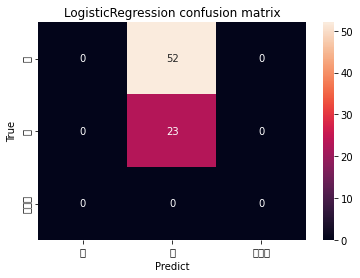

In [ ]:
# Check confusion matrix
label_name = ["漲", "跌", "無變化"]
mat = confusion_matrix(y_test, y_predict, labels=label_name)

print("score:",RCCV.score(X_test,y_test))
    
print("report:\n",classification_report(y_test,y_predict)) 
       
# Show confusion matrix
ax = plt.subplot()
sns.heatmap(mat,annot=True, fmt='g', ax=ax)
# labels, title and ticks
ax.set_xlabel('Predict');ax.set_ylabel('True')
title_name = 'LogisticRegression' + ' ' + 'confusion matrix'
ax.set_title(title_name)
ax.xaxis.set_ticklabels(label_name)
ax.yaxis.set_ticklabels(label_name)

4月份預測準確率: 0.3333333333333333
              precision    recall  f1-score   support

           漲       0.00      0.00      0.00        10
           跌       0.33      1.00      0.50         5

    accuracy                           0.33        15
   macro avg       0.17      0.50      0.25        15
weighted avg       0.11      0.33      0.17        15



,年月日-3,label,predict_label3
0,2020-04-03,跌,跌
1,2020-04-04,漲,跌
2,2020-04-05,漲,跌
3,2020-04-06,漲,跌
4,2020-04-07,漲,跌
5,2020-04-10,漲,跌
6,2020-04-11,跌,跌
7,2020-04-13,漲,跌
8,2020-04-14,漲,跌
9,2020-04-17,跌,跌


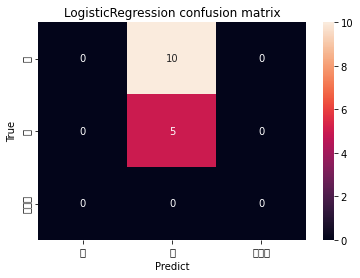

In [ ]:
# Predict
test_data['predict_label3'] = RCCV.predict(X_test) 
# Count the most common article type of the day, and predict
def get_more_articles(x):
  df = x.sort_values(by = 'title',ascending=False)
  return df

predict_label3 = test_data.groupby(['post_time', 'predict_label3']).count().sort_values('predict_label3', ascending = False).sort_index(level=[0], sort_remaining=False).groupby('post_time',as_index=False).apply(get_more_articles).groupby(level=0).head(1).reset_index()[['post_time', 'predict_label3']]
test_label = stock_data[stock_data['年月日-3'].between(test_startDate, test_endDate)][['年月日-3','label']]

result = pd.merge(test_label, predict_label3, left_on="年月日-3", right_on="post_time", how="left").drop('post_time',axis=1)
result = result.fillna(value="不出手")

result_notNA = pd.merge(test_label, predict_label3, left_on="年月日-3", right_on="post_time").drop('post_time',axis=1)

print('{}月份預測準確率:'.format(test_startDate.month), accuracy_score(result_notNA['label'], result_notNA['predict_label3']))
print(classification_report(result_notNA['label'], result_notNA['predict_label3']))

# Confusion Matrix
label_name = ["漲", "跌", "無變化"]
cm = confusion_matrix(result_notNA['label'], result_notNA['predict_label3'], labels=label_name)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
# labels, title and ticks
ax.set_xlabel('Predict');ax.set_ylabel('True')
title_name = 'LogisticRegression' + ' ' + 'confusion matrix'
ax.set_title(title_name)
ax.xaxis.set_ticklabels(label_name)
ax.yaxis.set_ticklabels(label_name)

result_notNA

In [ ]:
result

,年月日-3,label,predict_label3
0,2020-04-03,跌,跌
1,2020-04-04,漲,跌
2,2020-04-05,漲,跌
3,2020-04-06,漲,跌
4,2020-04-07,漲,跌
5,2020-04-10,漲,跌
6,2020-04-11,跌,跌
7,2020-04-12,漲,不出手
8,2020-04-13,漲,跌
9,2020-04-14,漲,跌


## 8) GaussianProcessClassifier

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier

GPC = GaussianProcessClassifier(random_state=1234)
GPC.fit(X_train,y_train)

y_predict = GPC.predict(X_test)

score: 0.30666666666666664
report:
               precision    recall  f1-score   support

           漲       0.00      0.00      0.00        52
           跌       0.31      1.00      0.47        23

    accuracy                           0.31        75
   macro avg       0.15      0.50      0.23        75
weighted avg       0.09      0.31      0.14        75



[Text(0, 0.5, '漲'), Text(0, 1.5, '跌'), Text(0, 2.5, '無變化')]

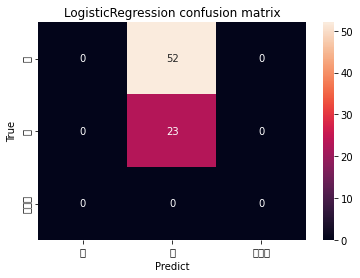

In [ ]:
# Check confusion matrix
label_name = ["漲", "跌", "無變化"]
mat = confusion_matrix(y_test, y_predict, labels=label_name)

print("score:",GPC.score(X_test,y_test))
    
print("report:\n",classification_report(y_test,y_predict)) 
       
# Show confusion matrix
ax = plt.subplot()
sns.heatmap(mat,annot=True, fmt='g', ax=ax)
# labels, title and ticks
ax.set_xlabel('Predict');ax.set_ylabel('True')
title_name = 'LogisticRegression' + ' ' + 'confusion matrix'
ax.set_title(title_name)
ax.xaxis.set_ticklabels(label_name)
ax.yaxis.set_ticklabels(label_name)

4月份預測準確率: 0.3333333333333333
              precision    recall  f1-score   support

           漲       0.00      0.00      0.00        10
           跌       0.33      1.00      0.50         5

    accuracy                           0.33        15
   macro avg       0.17      0.50      0.25        15
weighted avg       0.11      0.33      0.17        15



,年月日-3,label,predict_label3
0,2020-04-03,跌,跌
1,2020-04-04,漲,跌
2,2020-04-05,漲,跌
3,2020-04-06,漲,跌
4,2020-04-07,漲,跌
5,2020-04-10,漲,跌
6,2020-04-11,跌,跌
7,2020-04-13,漲,跌
8,2020-04-14,漲,跌
9,2020-04-17,跌,跌


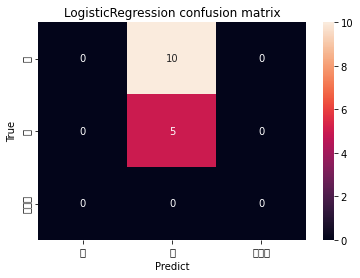

In [ ]:
# Predict
test_data['predict_label3'] = GPC.predict(X_test) 
# Count the most common article type of the day, and predict
def get_more_articles(x):
  df = x.sort_values(by = 'title',ascending=False)
  return df

predict_label3 = test_data.groupby(['post_time', 'predict_label3']).count().sort_values('predict_label3', ascending = False).sort_index(level=[0], sort_remaining=False).groupby('post_time',as_index=False).apply(get_more_articles).groupby(level=0).head(1).reset_index()[['post_time', 'predict_label3']]
test_label = stock_data[stock_data['年月日-3'].between(test_startDate, test_endDate)][['年月日-3','label']]

result = pd.merge(test_label, predict_label3, left_on="年月日-3", right_on="post_time", how="left").drop('post_time',axis=1)
result = result.fillna(value="不出手")

result_notNA = pd.merge(test_label, predict_label3, left_on="年月日-3", right_on="post_time").drop('post_time',axis=1)

print('{}月份預測準確率:'.format(test_startDate.month), accuracy_score(result_notNA['label'], result_notNA['predict_label3']))
print(classification_report(result_notNA['label'], result_notNA['predict_label3']))

# Confusion Matrix
label_name = ["漲", "跌", "無變化"]
cm = confusion_matrix(result_notNA['label'], result_notNA['predict_label3'], labels=label_name)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
# labels, title and ticks
ax.set_xlabel('Predict');ax.set_ylabel('True')
title_name = 'LogisticRegression' + ' ' + 'confusion matrix'
ax.set_title(title_name)
ax.xaxis.set_ticklabels(label_name)
ax.yaxis.set_ticklabels(label_name)

result_notNA

In [ ]:
result

,年月日-3,label,predict_label3
0,2020-04-03,跌,跌
1,2020-04-04,漲,跌
2,2020-04-05,漲,跌
3,2020-04-06,漲,跌
4,2020-04-07,漲,跌
5,2020-04-10,漲,跌
6,2020-04-11,跌,跌
7,2020-04-12,漲,不出手
8,2020-04-13,漲,跌
9,2020-04-14,漲,跌


## 9) XGboostModel

In [ ]:
from xgboost import XGBClassifier

XGBC = XGBClassifier()
XGBC.fit(X_train,y_train)

y_predict = XGBC.predict(X_test)

score: 0.38666666666666666
report:
               precision    recall  f1-score   support

           漲       0.88      0.13      0.23        52
           跌       0.33      0.96      0.49        23

    accuracy                           0.39        75
   macro avg       0.60      0.55      0.36        75
weighted avg       0.71      0.39      0.31        75



[Text(0, 0.5, '漲'), Text(0, 1.5, '跌'), Text(0, 2.5, '無變化')]

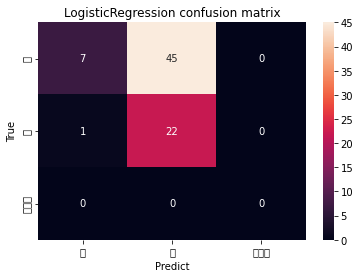

In [ ]:
# Check confusion matrix
label_name = ["漲", "跌", "無變化"]
mat = confusion_matrix(y_test, y_predict, labels=label_name)

print("score:",XGBC.score(X_test,y_test))
    
print("report:\n",classification_report(y_test,y_predict)) 
       
# Show confusion matrix
ax = plt.subplot()
sns.heatmap(mat,annot=True, fmt='g', ax=ax)
# labels, title and ticks
ax.set_xlabel('Predict');ax.set_ylabel('True')
title_name = 'LogisticRegression' + ' ' + 'confusion matrix'
ax.set_title(title_name)
ax.xaxis.set_ticklabels(label_name)
ax.yaxis.set_ticklabels(label_name)

4月份預測準確率: 0.3333333333333333
              precision    recall  f1-score   support

           漲       0.00      0.00      0.00        10
           跌       0.33      1.00      0.50         5

    accuracy                           0.33        15
   macro avg       0.17      0.50      0.25        15
weighted avg       0.11      0.33      0.17        15



,年月日-3,label,predict_label3
0,2020-04-03,跌,跌
1,2020-04-04,漲,跌
2,2020-04-05,漲,跌
3,2020-04-06,漲,跌
4,2020-04-07,漲,跌
5,2020-04-10,漲,跌
6,2020-04-11,跌,跌
7,2020-04-13,漲,跌
8,2020-04-14,漲,跌
9,2020-04-17,跌,跌


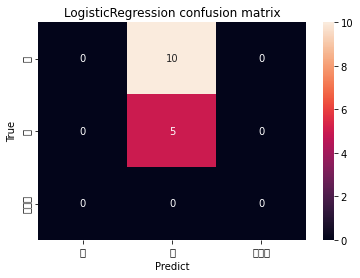

In [ ]:
# Predict
test_data['predict_label3'] = XGBC.predict(X_test) 
# Count the most common article type of the day, and predict
def get_more_articles(x):
  df = x.sort_values(by = 'title',ascending=False)
  return df

predict_label3 = test_data.groupby(['post_time', 'predict_label3']).count().sort_values('predict_label3', ascending = False).sort_index(level=[0], sort_remaining=False).groupby('post_time',as_index=False).apply(get_more_articles).groupby(level=0).head(1).reset_index()[['post_time', 'predict_label3']]
test_label = stock_data[stock_data['年月日-3'].between(test_startDate, test_endDate)][['年月日-3','label']]

result = pd.merge(test_label, predict_label3, left_on="年月日-3", right_on="post_time", how="left").drop('post_time',axis=1)
result = result.fillna(value="不出手")

result_notNA = pd.merge(test_label, predict_label3, left_on="年月日-3", right_on="post_time").drop('post_time',axis=1)

print('{}月份預測準確率:'.format(test_startDate.month), accuracy_score(result_notNA['label'], result_notNA['predict_label3']))
print(classification_report(result_notNA['label'], result_notNA['predict_label3']))

# Confusion Matrix
label_name = ["漲", "跌", "無變化"]
cm = confusion_matrix(result_notNA['label'], result_notNA['predict_label3'], labels=label_name)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
# labels, title and ticks
ax.set_xlabel('Predict');ax.set_ylabel('True')
title_name = 'LogisticRegression' + ' ' + 'confusion matrix'
ax.set_title(title_name)
ax.xaxis.set_ticklabels(label_name)
ax.yaxis.set_ticklabels(label_name)

result_notNA

In [ ]:
result

,年月日-3,label,predict_label3
0,2020-04-03,跌,跌
1,2020-04-04,漲,跌
2,2020-04-05,漲,跌
3,2020-04-06,漲,跌
4,2020-04-07,漲,跌
5,2020-04-10,漲,跌
6,2020-04-11,跌,跌
7,2020-04-12,漲,不出手
8,2020-04-13,漲,跌
9,2020-04-14,漲,跌


# 6. Back Testing
We try three model to do the back testing see which model perform better
1. Decission Tree
2. GradientBoostingClassifier
3. Random Forest


In [ ]:
def get_more_articles(x):
  df = x.sort_values(by = 'title',ascending=False)
  return df

In [ ]:
def backtesting(text_path,model_input):
  #accuracy=[]
  model_predicted_accuracy = []
  month_predicted_accuracy = []
  month_test_and_predicted_result = pd.DataFrame()
  month_range = range(1,10)
  for m in month_range:
      # Set every first three month as training data and M+3 as testing data
      # print(m) #train_data_start_month
      # print(m+2) #train_data_end_month
      # print(m+3)# test_data_start_month

      train_tokenStr_list = []      # Trainging data
      for i in list(text_path[text_path['post_time'].between(datetime.date(2020,m,1), datetime.date(2020,m+2,calendar.monthrange(2020,m+2)[1]))].index):
          try:
              sentence_list = utils.short_sentence(text_path['content'][i])
              tokenStr = str()
              for sentence in sentence_list:
                  tokens = monpa.cut(sentence)
                  for t in tokens:
                      t=t.strip()
                      if (len(t)>1):
                          tokenStr += ' '+(t)
              train_tokenStr_list.append(tokenStr)
          except:
              train_tokenStr_list.append('')

      test_tokenStr_list = []      # Testing data
      for i in list(text_path[text_path['post_time'].between(datetime.date(2020,m+3,1), datetime.date(2020,m+3,calendar.monthrange(2020,m+3)[1]))].index):
          try:
              sentence_list = utils.short_sentence(text_path['content'][i])
              tokenStr = str()
              for sentence in sentence_list:
                  tokens = monpa.cut(sentence)
                  for t in tokens:
                      t=t.strip()
                      if (len(t)>1):
                          tokenStr += ' '+(t)
              test_tokenStr_list.append(tokenStr)
          except:
              test_tokenStr_list.append('')
      # Vector space      
      vectorizer = TfidfVectorizer()
      X_train = vectorizer.fit_transform(train_tokenStr_list)
      X_train = pd.DataFrame(X_train.toarray(),columns=vectorizer.get_feature_names())
      y_train = text_path[text_path['post_time'].between(datetime.date(2020,m,1), datetime.date(2020,m+2,calendar.monthrange(2020,m+2)[1]))]['label']
      chi2_selector = SelectKBest(chi2, k = 2000)
      chi2_selector.fit(X_train, y_train)
      kbest_vocabs = X_train.columns[chi2_selector.get_support()]
      X_train = X_train[kbest_vocabs]
      y_test = text_path[text_path['post_time'].between(datetime.date(2020,m+3,1), datetime.date(2020,m+3,calendar.monthrange(2020,m+3)[1]))]['label']
      X_test = vectorizer.fit_transform(test_tokenStr_list)
      X_test = pd.DataFrame(X_test.toarray(),columns=vectorizer.get_feature_names())
      X_test = X_test.reindex(kbest_vocabs, axis=1, fill_value=0)

      model = model_input
      model.fit(X_train,y_train)
      y_predict = model.predict(X_test)
      

      test_data = text_path[text_path['post_time'].between(datetime.date(2020,m+3,1), datetime.date(2020,m+3,calendar.monthrange(2020,m+3)[1]))]

      test_data['predict_label3'] = model.predict(X_test) 

      predict_label3 = test_data.groupby(['post_time', 'predict_label3']).count().sort_values('predict_label3', ascending = False).sort_index(level=[0], sort_remaining=False).groupby('post_time',as_index=False).apply(get_more_articles).groupby(level=0).head(1).reset_index()[['post_time', 'predict_label3']]
      test_label = stock_data[stock_data['年月日-3'].between(datetime.date(2020,m+3,1), datetime.date(2020,m+3,calendar.monthrange(2020,m+3)[1]))][['年月日-3','label']]

      result = pd.merge(test_label, predict_label3, left_on="年月日-3", right_on="post_time", how="left").drop('post_time',axis=1)
      result = result.fillna(value="不出手")

      result_notNA = pd.merge(test_label, predict_label3, left_on="年月日-3", right_on="post_time").drop('post_time',axis=1)
      # Prediction
      model_predicted_accuracy.append(metrics.accuracy_score(y_test, y_predict))
      print(m+3,"月份文章準確率:",metrics.accuracy_score(y_test, y_predict))
      month_predicted_accuracy.append(accuracy_score(result_notNA['label'], result_notNA['predict_label3']))
      print(m+3,"月份單日漲跌準確率:",accuracy_score(result_notNA['label'], result_notNA['predict_label3']))
      month_test_and_predicted_result = pd.concat([month_test_and_predicted_result, result_notNA], ignore_index = True)
  print("文章平均準確率: ",np.mean(model_predicted_accuracy))
  print("單日漲跌平均準確率: ",np.mean(month_predicted_accuracy))
  print("單日漲跌預測結果比較表:\n ",month_test_and_predicted_result)
  fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
  mpl.rc('font', family='Taipei Sans TC Beta')
  month_range =  range(4,13)
  plt.xticks(month_range, ['2020-4','2020-5','2020-6',
                        '2020-7','2020-8','2020-9','2020-10','2020-11','2020-12'], rotation=45)
  plt.plot(month_range,month_predicted_accuracy,color='royalblue', label='每月漲跌預測準確率')
  plt.plot(month_range,model_predicted_accuracy,color='darkorange', label='每篇文章預測準確率')
  plt.plot(month_range,[np.mean(month_predicted_accuracy)]*9,color='royalblue',linestyle='--')
  plt.plot(month_range,[np.mean(model_predicted_accuracy)]*9,color='darkorange',linestyle='--')
  axes = plt.gca()
  axes.yaxis.grid()
  plt.legend()
  plt.show()
  return model_predicted_accuracy, month_predicted_accuracy, month_test_and_predicted_result

### Decision Tree  


4 月份文章準確率: 0.4
4 月份單日漲跌準確率: 0.3333333333333333
5 月份文章準確率: 0.4722222222222222
5 月份單日漲跌準確率: 0.5555555555555556
6 月份文章準確率: 0.48
6 月份單日漲跌準確率: 0.47058823529411764
7 月份文章準確率: 0.5576923076923077
7 月份單日漲跌準確率: 0.5294117647058824
8 月份文章準確率: 0.5
8 月份單日漲跌準確率: 0.5625
9 月份文章準確率: 0.3951612903225806
9 月份單日漲跌準確率: 0.47058823529411764
10 月份文章準確率: 0.49122807017543857
10 月份單日漲跌準確率: 0.6470588235294118
11 月份文章準確率: 0.5773809523809523
11 月份單日漲跌準確率: 0.6
12 月份文章準確率: 0.6520376175548589
12 月份單日漲跌準確率: 0.7
文章平均準確率:  0.5028580511498179
單日漲跌平均準確率:  0.5410039941902687
單日漲跌預測結果比較表:
            年月日-3 label predict_label3
0    2020-04-03     跌              跌
1    2020-04-04     漲              跌
2    2020-04-05     漲              跌
3    2020-04-06     漲              跌
4    2020-04-07     漲              跌
5    2020-04-10     漲              跌
6    2020-04-11     跌              跌
7    2020-04-13     漲              跌
8    2020-04-14     漲              跌
9    2020-04-17     跌              跌
10   2020-04-19     跌              跌


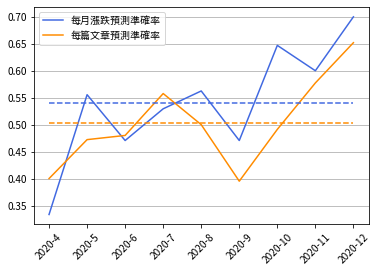

In [ ]:
dt_model_predicted_accuracy, dt_month_predicted_accuracy, dt_month_test_and_predicted_result = backtesting(text_data,DecisionTreeClassifier(criterion="entropy",random_state=1234))

### GradientBoostingClassifier

4 月份文章準確率: 0.32
4 月份單日漲跌準確率: 0.3333333333333333
5 月份文章準確率: 0.4444444444444444
5 月份單日漲跌準確率: 0.5
6 月份文章準確率: 0.41333333333333333
6 月份單日漲跌準確率: 0.29411764705882354
7 月份文章準確率: 0.5384615384615384
7 月份單日漲跌準確率: 0.5882352941176471
8 月份文章準確率: 0.37755102040816324
8 月份單日漲跌準確率: 0.3125
9 月份文章準確率: 0.3387096774193548
9 月份單日漲跌準確率: 0.4117647058823529
10 月份文章準確率: 0.5175438596491229
10 月份單日漲跌準確率: 0.7647058823529411
11 月份文章準確率: 0.75
11 月份單日漲跌準確率: 0.85
12 月份文章準確率: 0.8150470219435737
12 月份單日漲跌準確率: 0.8
文章平均準確率:  0.5016767661843924
單日漲跌平均準確率:  0.5394063180827886
單日漲跌預測結果比較表:
            年月日-3 label predict_label3
0    2020-04-03     跌              跌
1    2020-04-04     漲              跌
2    2020-04-05     漲              跌
3    2020-04-06     漲              跌
4    2020-04-07     漲              跌
5    2020-04-10     漲              跌
6    2020-04-11     跌              跌
7    2020-04-13     漲              跌
8    2020-04-14     漲              跌
9    2020-04-17     跌              跌
10   2020-04-19     跌              

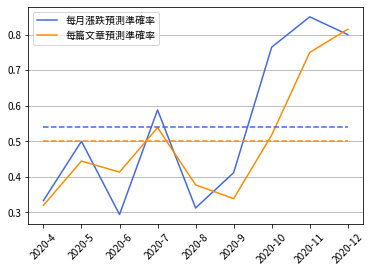

In [ ]:
gbc_model_predicted_accuracy, gbc_month_predicted_accuracy, gbc_month_test_and_predicted_result = backtesting(text_data,ensemble.GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.05,random_state=1234))

### RandomForest

4 月份文章準確率: 0.30666666666666664
4 月份單日漲跌準確率: 0.3333333333333333
5 月份文章準確率: 0.5138888888888888
5 月份單日漲跌準確率: 0.6111111111111112
6 月份文章準確率: 0.4533333333333333
6 月份單日漲跌準確率: 0.5294117647058824
7 月份文章準確率: 0.46153846153846156
7 月份單日漲跌準確率: 0.47058823529411764
8 月份文章準確率: 0.45918367346938777
8 月份單日漲跌準確率: 0.5625
9 月份文章準確率: 0.3951612903225806
9 月份單日漲跌準確率: 0.4117647058823529
10 月份文章準確率: 0.6140350877192983
10 月份單日漲跌準確率: 0.8235294117647058
11 月份文章準確率: 0.8392857142857143
11 月份單日漲跌準確率: 0.8
12 月份文章準確率: 0.8401253918495298
12 月份單日漲跌準確率: 0.8
文章平均準確率:  0.5425798342304291
單日漲跌平均準確率:  0.5935820624546114
單日漲跌預測結果比較表:
            年月日-3 label predict_label3
0    2020-04-03     跌              跌
1    2020-04-04     漲              跌
2    2020-04-05     漲              跌
3    2020-04-06     漲              跌
4    2020-04-07     漲              跌
5    2020-04-10     漲              跌
6    2020-04-11     跌              跌
7    2020-04-13     漲              跌
8    2020-04-14     漲              跌
9    2020-04-17     跌        

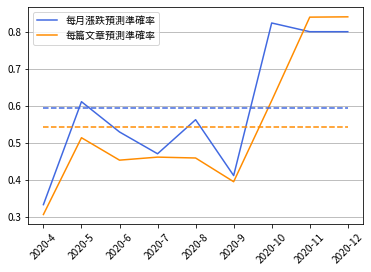

In [ ]:
rf_model_predicted_accuracy, rf_month_predicted_accuracy, rf_month_test_and_predicted_result = backtesting(text_data,ensemble.RandomForestClassifier(n_estimators = 100,random_state=1234))